- Gestión dinámica de inventario día a día (físico y digital).
- Política de reabastecimiento up-to-level (Q_i, T).
- Cálculo de costos y métricas diarias.
- Modelo de aceptación de despacho express.


## Carga de Datos Reales y Configuración Inicial

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [72]:
# Función para cargar ventas
def cargar_ventas(ruta_base, tipo):
    ventas = []
    for dia in range(1, 41):
        archivo = f"{ruta_base}_{dia}_20250115.csv"
        if os.path.exists(archivo):
            df = pd.read_csv(archivo)
            df['dia'] = dia
            ventas.append(df)
    return pd.concat(ventas, ignore_index=True)

# Carga de datos únicos
flota = pd.read_csv('flota_20250115.csv')
productos = pd.read_csv('productos_20250115.csv')
proporcion_eleccion = pd.read_csv('proporcion_eleccion_de_usuarios_20250115.csv')
#demanda_insatisfecha = pd.read_csv('demanda_online_insatisfecha_20250115.csv')
reorden = pd.read_csv('reorden_20250115.csv')
tiendas = pd.read_csv('tiendas_20250115.csv')
vehiculos = pd.read_csv('vehiculos_20250115.csv')
zonas = pd.read_csv('zonas_20250115.csv')

# Carga de ventas físicas y digitales
ventas_tienda = cargar_ventas('venta_tienda', 'tienda')
ventas_zona = cargar_ventas('venta_zona', 'zona')

costo_inventario_unitario = 3.733

Agrego las distribuciones para el enfoque híbrido.

In [73]:
# ===============================
# Cargar los ajustes de distribuciones por producto
# ===============================

# Cargar desde los archivos de resumen de ajustes
distribuciones_tienda = pd.read_excel('resumen_tiendas.xlsx')
distribuciones_zona = pd.read_excel('resumen_zonas.xlsx')

# Revisar algunas filas
print("Distribuciones tienda:")
print(distribuciones_tienda.head())

print("Distribuciones zona:")
print(distribuciones_zona.head())

Distribuciones tienda:
   id_producto  pvalue_normal  pvalue_poisson  pvalue_gamma  pvalue_lognorm  \
0            1       0.256858    1.565143e-02      0.446055        0.596663   
1            2       0.002863    1.046412e-08      0.005432        0.007642   
2            3       0.000163    5.751501e-10      0.000414        0.000680   
3            4       0.000022    9.303059e-15      0.000043        0.000062   
4            5       0.038732    7.883678e-02      0.161589        0.301996   

  mejor_ajuste  
0   Log-Normal  
1   Log-Normal  
2   Log-Normal  
3   Log-Normal  
4   Log-Normal  
Distribuciones zona:
   id_producto  pvalue_normal  pvalue_poisson  pvalue_gamma  pvalue_lognorm  \
0            1            NaN             NaN           NaN             NaN   
1            2       0.996615        0.136685      0.995499        0.994848   
2            3       0.987937        0.128006      0.988811        0.989234   
3            4       0.997504        0.008310      0.998130    

In [74]:
ventas_tienda.rename(columns={'venta_tienda': 'cantidad'}, inplace=True)
ventas_zona.rename(columns={'venta_digital': 'cantidad'}, inplace=True)

# Unificar las ventas observadas físicas y digitales
ventas_historicas = pd.concat([
    ventas_tienda[['id_producto', 'cantidad']],
    ventas_zona[['id_producto', 'cantidad']]
], ignore_index=True)


ventas_historicas.head()

,id_producto,cantidad
0,1,0
1,2,19
2,3,21
3,4,38
4,5,2


In [75]:
print("Ventas físicas:")
print(ventas_tienda['cantidad'].describe())
print("Valores <= 0:", (ventas_tienda['cantidad'] <= 0).sum())

print("\nVentas digitales:")
print(ventas_zona['cantidad'].describe())
print("Valores <= 0:", (ventas_zona['cantidad'] <= 0).sum())


Ventas físicas:
count    689520.000000
mean         33.535071
std          25.277880
min           0.000000
25%          15.000000
50%          29.000000
75%          47.000000
max         200.000000
Name: cantidad, dtype: float64
Valores <= 0: 14818

Ventas digitales:
count    8.517600e+07
mean     2.061633e+01
std      1.789347e+01
min      0.000000e+00
25%      7.000000e+00
50%      1.600000e+01
75%      2.900000e+01
max      2.240000e+02
Name: cantidad, dtype: float64
Valores <= 0: 2596987


Generar resumen tiendas con parametros:

In [76]:
from scipy.stats import norm, lognorm, gamma, poisson
import numpy as np
import pandas as pd

# === 1. Unir ventas físicas y digitales ===
ventas_historicas = pd.concat([
    ventas_tienda[['id_producto', 'cantidad']],
    ventas_zona[['id_producto', 'cantidad']]
], ignore_index=True)

# === 2. Ajustar distribuciones por producto usando solo días con demanda positiva ===
parametros = []

for id_producto, grupo in ventas_historicas.groupby("id_producto"):
    cantidades = grupo["cantidad"].values
    positivas = cantidades[cantidades > 0]

    # Normal (puede incluir ceros)
    mu, sigma = norm.fit(cantidades)
    parametros.append({
        'id_producto': id_producto,
        'distribucion': 'Normal',
        'parametro1': mu,
        'parametro2': sigma
    })

    # Log-Normal
    if len(positivas) > 0:
        try:
            shape, loc, scale = lognorm.fit(positivas, floc=0)
            mu_ln = np.log(scale)
            sigma_ln = shape
            parametros.append({
                'id_producto': id_producto,
                'distribucion': 'Log-Normal',
                'parametro1': mu_ln,
                'parametro2': sigma_ln
            })
        except Exception as e:
            print(f"[Log-Normal] Producto {id_producto} falló: {e}")

    # Gamma
    if len(positivas) > 0:
        try:
            shape_g, loc_g, scale_g = gamma.fit(positivas, floc=0)
            parametros.append({
                'id_producto': id_producto,
                'distribucion': 'Gamma',
                'parametro1': shape_g,
                'parametro2': scale_g
            })
        except Exception as e:
            print(f"[Gamma] Producto {id_producto} falló: {e}")

    # Poisson (permite ceros)
    lambda_p = cantidades.mean()
    parametros.append({
        'id_producto': id_producto,
        'distribucion': 'Poisson',
        'parametro1': lambda_p,
        'parametro2': None
    })

df_parametros = pd.DataFrame(parametros)


In [77]:
# Cargar archivo original que tiene la columna 'mejor_ajuste'
resumen = pd.read_excel('resumen_tiendas.xlsx')  # o 'resumen_zonas.xlsx'

# Fusionar para tomar solo la fila con la distribución elegida
df_completo = resumen.merge(
    df_parametros,
    left_on=['id_producto', 'mejor_ajuste'],
    right_on=['id_producto', 'distribucion'],
    how='left'
)

# Eliminar columna auxiliar
df_completo.drop(columns=['distribucion'], inplace=True)

# Guardar Excel final listo para simulación
df_completo.to_excel('resumen_tiendas_con_parametros.xlsx', index=False)


Generar resumen zonas con parametros:

In [78]:
# === 1. Ajuste sobre ventas digitales (zonas) ===
parametros_zona = []

for id_producto, grupo in ventas_zona.groupby("id_producto"):
    cantidades = grupo["cantidad"].values
    positivas = cantidades[cantidades > 0]

    # Normal
    mu, sigma = norm.fit(cantidades)
    parametros_zona.append({'id_producto': id_producto, 'distribucion': 'Normal', 'parametro1': mu, 'parametro2': sigma})

    # Log-Normal
    if len(positivas) > 0:
        try:
            shape, loc, scale = lognorm.fit(positivas, floc=0)
            mu_ln = np.log(scale)
            sigma_ln = shape
            parametros_zona.append({
                'id_producto': id_producto,
                'distribucion': 'Log-Normal',
                'parametro1': mu_ln,
                'parametro2': sigma_ln
            })
        except:
            pass

    # Gamma
    if len(positivas) > 0:
        try:
            shape_g, loc_g, scale_g = gamma.fit(positivas, floc=0)
            parametros_zona.append({
                'id_producto': id_producto,
                'distribucion': 'Gamma',
                'parametro1': shape_g,
                'parametro2': scale_g
            })
        except:
            pass

    # Poisson
    lambda_p = cantidades.mean()
    parametros_zona.append({'id_producto': id_producto, 'distribucion': 'Poisson', 'parametro1': lambda_p, 'parametro2': None})

df_param_zona = pd.DataFrame(parametros_zona)

# === 2. Fusionar con el resumen original de zonas
resumen_zona = pd.read_excel('resumen_zonas.xlsx')

df_zona_completo = resumen_zona.merge(
    df_param_zona,
    left_on=['id_producto', 'mejor_ajuste'],
    right_on=['id_producto', 'distribucion'],
    how='left'
)

df_zona_completo.drop(columns=['distribucion'], inplace=True)

# === 3. Guardar
df_zona_completo.to_excel('resumen_zonas_con_parametros.xlsx', index=False)


C:\Users\raulr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_continuous_distns.py:3736: RuntimeWarning: divide by zero encountered in scalar divide
  aest = (3-s + np.sqrt((s-3)**2 + 24*s)) / (12*s)
C:\Users\raulr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_continuous_distns.py:3739: RuntimeWarning: invalid value encountered in scalar subtract
  a = optimize.brentq(lambda a: np.log(a) - sc.digamma(a) - s,


Estimación de los parámetros desde la Demanda Histórica

In [79]:
# ===============================
# Estimación de parámetros desde la demanda observada
# ===============================

parametros_estimados = ventas_historicas.groupby('id_producto').agg(
    media=('cantidad', 'mean'),
    desviacion=('cantidad', 'std')
).reset_index()

# Visualizar los parámetros estimados
print(parametros_estimados.head())


   id_producto      media  desviacion
0            1   0.426323    0.503162
1            2  17.543446    9.578386
2            3  19.059412   10.385503
3            4  31.033337   16.674072
4            5   1.125897    0.708352


## Inicialización de Stock para Cada Tienda y Producto

In [80]:
# Inicializar stock directamente desde reorden, incluyendo todo
stock = reorden.copy()
stock['stock_actual'] = stock['reorden']

# Si todos tienen la misma frecuencia
frecuencia_reabastecimiento = stock['frecuencia_reorden'].iloc[0]

# Mostrar el stock inicial
print("Stock inicial por tienda y producto:")
print(stock.head())



Stock inicial por tienda y producto:
   Unnamed: 0  id_tienda  id_producto  reorden  frecuencia_reorden  \
0           0          1            1      240                   5   
1           1          1            2    11005                   5   
2           2          1            3    11915                   5   
3           3          1            4    19180                   5   
4           4          1            5      685                   5   

   stock_actual  
0           240  
1         11005  
2         11915  
3         19180  
4           685  


In [81]:
print(stock)

       Unnamed: 0  id_tienda  id_producto  reorden  frecuencia_reorden  \
0               0          1            1      240                   5   
1               1          1            2    11005                   5   
2               2          1            3    11915                   5   
3               3          1            4    19180                   5   
4               4          1            5      685                   5   
...           ...        ...          ...      ...                 ...   
17233       17233         17         1010     7280                   5   
17234       17234         17         1011      345                   5   
17235       17235         17         1012     7095                   5   
17236       17236         17         1013     1305                   5   
17237       17237         17         1014    19545                   5   

       stock_actual  
0               240  
1             11005  
2             11915  
3             19180  
4

Preparar Resultados para Registrar Día a Día

In [82]:
def generar_variacion_estocastica(distribucion, param1, param2=None):
    """
    Genera una variación estocástica según la distribución especificada.

    distribucion: str, nombre de la distribución ('Poisson', 'Normal', 'Uniforme', 'LogNormal', 'Gamma', 'Constante')
    param1: primer parámetro (lambda, media, min, etc.)
    param2: segundo parámetro (desviación estándar, max, etc.)
    """
    if pd.isna(param1) or (param2 is not None and pd.isna(param2)):
        return 0  # No hay datos suficientes

    if distribucion == 'Poisson':
        return np.random.poisson(lam=param1)
    
    elif distribucion == 'Normal':
        if param2 is None:
            return 0
        return max(0, int(np.random.normal(loc=param1, scale=param2)))
    
    elif distribucion == 'Uniforme':
        if param2 is None:
            return 0
        return np.random.randint(int(param1), int(param2) + 1)
    
    elif distribucion == 'Log-Normal' or distribucion == 'LogNormal':
        if param2 is None:
            return 0
        return max(0, int(np.random.lognormal(mean=param1, sigma=param2)))
    
    elif distribucion == 'Gamma':
        if param2 is None:
            return 0
        return max(0, int(np.random.gamma(shape=param1, scale=param2)))
    
    elif distribucion == 'Constante':
        return int(param1)
    
    else:
        # Si la distribución no se reconoce, no se agrega variación
        return 0


## Simulación de Consumo y Reabastecimiento Día a Día (Caso Base)

In [83]:
# Crear una lista vacía para guardar el estado diario
registro_dia_a_dia = []


In [84]:
# Cargar parámetros
distribuciones_tienda = pd.read_excel('resumen_tiendas_con_parametros.xlsx')
distribuciones_zona = pd.read_excel('resumen_zonas_con_parametros.xlsx')

# Configuración
dias_simulados = 10
costo_inventario_unitario = 3.733
frecuencia_reabastecimiento = 5

# Inicializar stock desde reorden y pasar a índice más eficiente
stock = reorden[['id_tienda', 'id_producto', 'reorden']].copy()
stock['stock_actual'] = stock['reorden']
stock.set_index(['id_tienda', 'id_producto'], inplace=True)

# Registro de resultados
registro_dia_a_dia = []
costo_inventario_total = 0

# Simulación principal
for dia in range(1, dias_simulados + 1):
    # Cargar ventas
    vt = ventas_tienda[ventas_tienda['dia'] == dia].copy()
    vt.rename(columns={'venta_tienda': 'cantidad'}, inplace=True)
    vz = ventas_zona[ventas_zona['dia'] == dia].copy()
    vz.rename(columns={'venta_digital': 'cantidad'}, inplace=True)

    # Agrupar demanda
    demanda_dia = pd.concat([vt, vz], ignore_index=True)
    demanda_dia = demanda_dia.groupby(['id_tienda', 'id_producto'])['cantidad'].sum().reset_index()

    # Ajustar demanda
    demanda_ajustada = []
    for _, row in demanda_dia.iterrows():
        id_tienda = row['id_tienda']
        id_producto = row['id_producto']
        base = row['cantidad']

        fila_t = distribuciones_tienda[distribuciones_tienda['id_producto'] == id_producto]
        fila_z = distribuciones_zona[distribuciones_zona['id_producto'] == id_producto]

        if not fila_t.empty:
            dist = fila_t['mejor_ajuste'].values[0]
            p1 = fila_t['parametro1'].values[0]
            p2 = fila_t['parametro2'].values[0] if 'parametro2' in fila_t.columns else None
        elif not fila_z.empty:
            dist = fila_z['mejor_ajuste'].values[0]
            p1 = fila_z['parametro1'].values[0]
            p2 = fila_z['parametro2'].values[0] if 'parametro2' in fila_z.columns else None
        else:
            dist, p1, p2 = None, None, None

        variacion = generar_variacion_estocastica(dist, p1, p2) if dist else 0
        total = max(0, int(base + variacion))
        demanda_ajustada.append((id_tienda, id_producto, total))

    # Procesar demanda
    for id_tienda, id_producto, cantidad in demanda_ajustada:
        if (id_tienda, id_producto) in stock.index:
            disponible = stock.at[(id_tienda, id_producto), 'stock_actual']
            atendido = min(disponible, cantidad)
            no_atendido = cantidad - atendido
            stock.at[(id_tienda, id_producto), 'stock_actual'] -= atendido

            registro_dia_a_dia.append({
                'dia': dia,
                'id_tienda': id_tienda,
                'id_producto': id_producto,
                'demanda': cantidad,
                'atendido': atendido,
                'no_atendido': no_atendido,
                'stock_restante': stock.at[(id_tienda, id_producto), 'stock_actual']
            })

    # Calcular costo del día
    stock_total = stock['stock_actual'].sum()
    costo_dia = stock_total * costo_inventario_unitario
    costo_inventario_total += costo_dia

    # Reabastecer si corresponde
    if dia % frecuencia_reabastecimiento == 0:
        stock['stock_actual'] += stock['reorden'] - stock['stock_actual']

# KPIs finales
resultados_df = pd.DataFrame(registro_dia_a_dia)
nivel_servicio = resultados_df['atendido'].sum() / resultados_df['demanda'].sum()
costo_diario_promedio = costo_inventario_total / dias_simulados
demanda_no_atendida_total = resultados_df['no_atendido'].sum()
top_n_productos = resultados_df.groupby('id_producto')['no_atendido'] \
                               .sum().sort_values(ascending=False).head(10).reset_index()

# Mostrar KPIs
print(f"Nivel de servicio: {nivel_servicio:.2%}")
print(f"Costo total de inventario: ${costo_inventario_total:,.0f}")
print(f"Costo diario promedio: ${costo_diario_promedio:,.2f}")
print(f"Demanda no atendida total: {demanda_no_atendida_total:,.0f}")
print("\nTop 10 productos con más unidades no atendidas:")
display(top_n_productos)


Nivel de servicio: 100.00%
Costo total de inventario: $8,395,632,353
Costo diario promedio: $839,563,235.34
Demanda no atendida total: 149

Top 10 productos con más unidades no atendidas:


,id_producto,no_atendido
0,269.0,147
1,119.0,1
2,566.0,1
3,22.0,0
4,999.0,0
5,998.0,0
6,7.0,0
7,1014.0,0
8,5.0,0
9,8.0,0


In [88]:
reorden['reorden'].describe()


count    17238.00000
mean     13205.86959
std      10762.06675
min          0.00000
25%       5110.00000
50%      10485.00000
75%      18672.50000
max      62415.00000
Name: reorden, dtype: float64

In [89]:
stock['stock_actual'].sum()


np.int64(227642780)

In [90]:
print("Costo día 1:", stock['stock_actual'].sum() * costo_inventario_unitario)


Costo día 1: 849790497.74


In [91]:
reorden.head()

,Unnamed: 0,id_tienda,id_producto,reorden,frecuencia_reorden
0,0,1,1,240,5
1,1,1,2,11005,5
2,2,1,3,11915,5
3,3,1,4,19180,5
4,4,1,5,685,5


In [93]:
len(stock)


17238

## Consolidación de Resultados Diarios (Caso Base)

In [85]:
# Convertir el registro a un DataFrame para análisis posterior
resultados_df = pd.DataFrame(registro_dia_a_dia)

# Mostrar las primeras filas para revisar el comportamiento
print("Resumen de la evolución del inventario día a día:")
print(resultados_df)


Resumen de la evolución del inventario día a día:
        dia  id_tienda  id_producto  demanda  atendido  no_atendido  \
0         1        1.0          1.0        1         1            0   
1         1        1.0          2.0       29        29            0   
2         1        1.0          3.0       39        39            0   
3         1        1.0          4.0       68        68            0   
4         1        1.0          5.0        3         3            0   
...     ...        ...          ...      ...       ...          ...   
172375   10       17.0       1010.0       57        57            0   
172376   10       17.0       1011.0        2         2            0   
172377   10       17.0       1012.0       38        38            0   
172378   10       17.0       1013.0       12        12            0   
172379   10       17.0       1014.0      136       136            0   

        stock_restante  
0                  239  
1                10976  
2                11876

Resumir Métricas por Día

In [86]:
# Resumen por día para ver cómo evolucionó la operación
resumen_dia = resultados_df.groupby('dia').agg({
    'demanda': 'sum',
    'atendido': 'sum',
    'no_atendido': 'sum'
}).reset_index()

print("Resumen diario de demanda, atendido y no atendido:")
print(resumen_dia)


Resumen diario de demanda, atendido y no atendido:
   dia  demanda  atendido  no_atendido
0    1   901966    901960            6
1    2   896843    896835            8
2    3   897663    897654            9
3    4   899438    899418           20
4    5  1106839   1106810           29
5    6   900659    900654            5
6    7   896724    896716            8
7    8   900598    900588           10
8    9   899521    899493           28
9   10  1110293   1110267           26


In [94]:
import matplotlib.pyplot as plt

# Agrupar por día y sumar el costo de inventario diario
costo_por_dia = pd.DataFrame(registro_dia_a_dia).groupby('dia')['costo_inventario_dia'].sum().reset_index()

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(costo_por_dia['dia'], costo_por_dia['costo_inventario_dia'], marker='o', color='purple')
plt.title('Costo Diario de Inventario')
plt.xlabel('Día')
plt.ylabel('Costo de Inventario ($)')
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: 'Column not found: costo_inventario_dia'

Gráfico de Evolución de Demanda y Atención Diaria

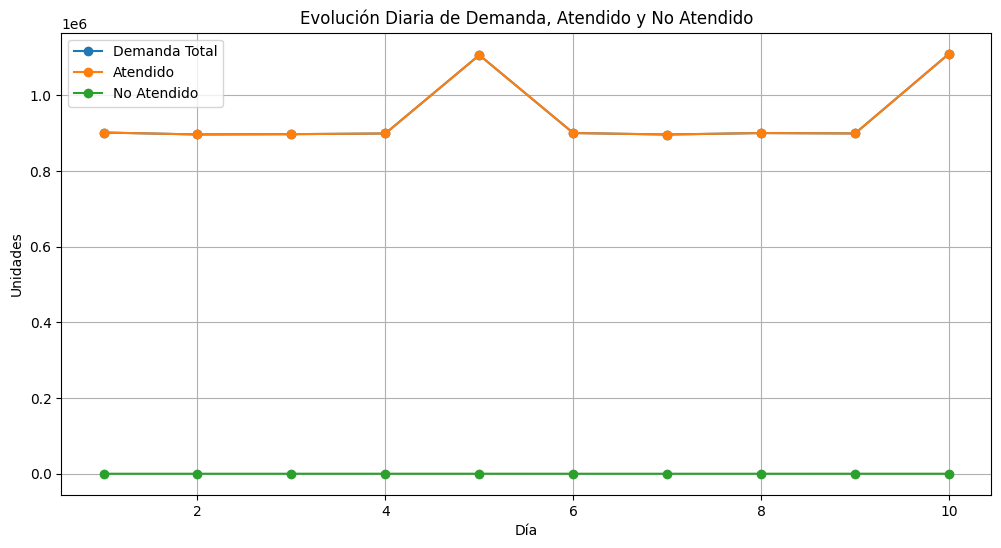

In [95]:
import matplotlib.pyplot as plt

# Graficar demanda, atendido y no atendido
plt.figure(figsize=(12, 6))
plt.plot(resumen_dia['dia'], resumen_dia['demanda'], label='Demanda Total', marker='o')
plt.plot(resumen_dia['dia'], resumen_dia['atendido'], label='Atendido', marker='o')
plt.plot(resumen_dia['dia'], resumen_dia['no_atendido'], label='No Atendido', marker='o')
plt.xlabel('Día')
plt.ylabel('Unidades')
plt.title('Evolución Diaria de Demanda, Atendido y No Atendido')
plt.legend()
plt.grid(True)
plt.show()


Gráfico del Nivel de Servicio Acumulado

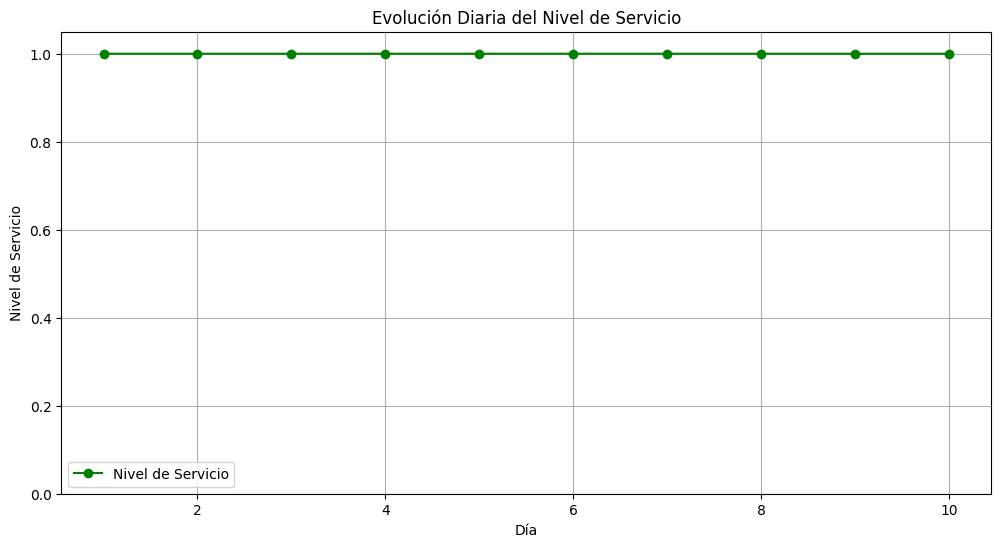

In [96]:
# Calcular nivel de servicio acumulado día a día
resumen_dia['nivel_servicio'] = resumen_dia['atendido'] / resumen_dia['demanda']
    
plt.figure(figsize=(12, 6))
plt.plot(resumen_dia['dia'], resumen_dia['nivel_servicio'], label='Nivel de Servicio', color='green', marker='o')
plt.xlabel('Día')
plt.ylabel('Nivel de Servicio')
plt.title('Evolución Diaria del Nivel de Servicio')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()

Peores Días

In [97]:
# Ordenar los días con mayor cantidad de demanda no atendida
peores_dias = resumen_dia.sort_values('no_atendido', ascending=False).head(10)

print("Top 10 días con mayor cantidad de demanda no atendida:")
print(peores_dias)


Top 10 días con mayor cantidad de demanda no atendida:
   dia  demanda  atendido  no_atendido  nivel_servicio
4    5  1106839   1106810           29        0.999974
8    9   899521    899493           28        0.999969
9   10  1110293   1110267           26        0.999977
3    4   899438    899418           20        0.999978
7    8   900598    900588           10        0.999989
2    3   897663    897654            9        0.999990
6    7   896724    896716            8        0.999991
1    2   896843    896835            8        0.999991
0    1   901966    901960            6        0.999993
5    6   900659    900654            5        0.999994


Peores Tiendas con Más Demanda No Atendida

In [98]:
# Agrupar por tienda
peores_tiendas = resultados_df.groupby('id_tienda').agg({
    'demanda': 'sum',
    'atendido': 'sum',
    'no_atendido': 'sum'
}).sort_values('no_atendido', ascending=False).head(10)

print("Top 10 tiendas con mayor demanda no atendida acumulada:")
print(peores_tiendas)


Top 10 tiendas con mayor demanda no atendida acumulada:
           demanda  atendido  no_atendido
id_tienda                                
5.0         465332    465318           14
10.0        498348    498336           12
2.0         539814    539802           12
11.0        527428    527417           11
3.0         396017    396006           11
4.0         422652    422642           10
16.0        825964    825954           10
1.0         469924    469915            9
7.0         456083    456074            9
8.0         398128    398119            9


Función de Simulación Parametrizable

In [114]:
def simular_gestion_inventario(Q_factor=1.0, T=5, dias=10, costo_inventario_unitario=3.733):
    # Inicializar stock con índice eficiente
    stock = reorden[['id_tienda', 'id_producto', 'reorden']].copy()
    stock['reorden'] = (stock['reorden'] * Q_factor).astype(int)
    stock['stock_actual'] = stock['reorden']
    stock.set_index(['id_tienda', 'id_producto'], inplace=True)

    registro = []
    costo_inventario_total = 0

    for dia in range(1, dias + 1):
        vt = ventas_tienda[ventas_tienda['dia'] == dia].copy()
        vt.rename(columns={'venta_tienda': 'cantidad'}, inplace=True)
        vz = ventas_zona[ventas_zona['dia'] == dia].copy()
        vz.rename(columns={'venta_digital': 'cantidad'}, inplace=True)

        demanda_dia = pd.concat([vt, vz], ignore_index=True)
        demanda_dia = demanda_dia.groupby(['id_tienda', 'id_producto'])['cantidad'].sum().reset_index()

        demanda_ajustada = []
        for _, row in demanda_dia.iterrows():
            id_tienda = row['id_tienda']
            id_producto = row['id_producto']
            base = row['cantidad']

            fila_t = distribuciones_tienda[distribuciones_tienda['id_producto'] == id_producto]
            fila_z = distribuciones_zona[distribuciones_zona['id_producto'] == id_producto]

            if not fila_t.empty:
                dist = fila_t['mejor_ajuste'].values[0]
                p1 = fila_t['parametro1'].values[0]
                p2 = fila_t['parametro2'].values[0] if 'parametro2' in fila_t.columns else None
            elif not fila_z.empty:
                dist = fila_z['mejor_ajuste'].values[0]
                p1 = fila_z['parametro1'].values[0]
                p2 = fila_z['parametro2'].values[0] if 'parametro2' in fila_z.columns else None
            else:
                dist, p1, p2 = None, None, None

            variacion = generar_variacion_estocastica(dist, p1, p2) if dist else 0
            total = max(0, int(base + variacion))
            demanda_ajustada.append((id_tienda, id_producto, total))

        for id_tienda, id_producto, cantidad in demanda_ajustada:
            if (id_tienda, id_producto) in stock.index:
                disponible = stock.at[(id_tienda, id_producto), 'stock_actual']
                atendido = min(disponible, cantidad)
                no_atendido = cantidad - atendido
                stock.at[(id_tienda, id_producto), 'stock_actual'] -= atendido

                registro.append({
                    'dia': dia,
                    'id_tienda': id_tienda,
                    'id_producto': id_producto,
                    'demanda': cantidad,
                    'atendido': atendido,
                    'no_atendido': no_atendido,
                    'stock_restante': stock.at[(id_tienda, id_producto), 'stock_actual']
                })

        # Costo del día
        stock_total = stock['stock_actual'].sum()
        costo_dia = stock_total * costo_inventario_unitario
        costo_inventario_total += costo_dia

        if dia % T == 0:
            stock['stock_actual'] += stock['reorden'] - stock['stock_actual']

    df = pd.DataFrame(registro)
    demanda_total = df['demanda'].sum()
    atendido_total = df['atendido'].sum()
    no_atendido_total = df['no_atendido'].sum()

    return {
        'Q_factor': Q_factor,
        'T': T,
        'Nivel_Servicio': atendido_total / demanda_total if demanda_total > 0 else 0,
        'Costo_Inventario_Total': costo_inventario_total,
        'Costo_Diario_Promedio': costo_inventario_total / dias,
        'Demanda_No_Atendida_Total': no_atendido_total*4,
        'Top_10_Productos_Con_Quiebre': df.groupby('id_producto')['no_atendido'].sum().sort_values(ascending=False).head(10).reset_index(),
        'Resultados_Detallados': df
    }


# Análisis de Sensibilidad sobre Q y T

In [116]:
factores_Q = [0.05, 0.075, 0.1]
frecuencias_T = [3, 7, 10]
dias_simulados = 10
costo_unitario = 3.733

resultados_sensibilidad = []

for Q in factores_Q:
    for T in frecuencias_T:
        res = simular_gestion_inventario(Q_factor=Q, T=T, dias=dias_simulados, costo_inventario_unitario=costo_unitario)
        resultados_sensibilidad.append({
            'Q_factor': Q,
            'T': T,
            'Nivel_Servicio': res['Nivel_Servicio'],
            'Costo_Inventario_Total': res['Costo_Inventario_Total'],
            'Costo_Diario_Promedio': res['Costo_Diario_Promedio'],
            'Demanda_No_Atendida_Total': res['Demanda_No_Atendida_Total']
        })

df_sensibilidad = pd.DataFrame(resultados_sensibilidad)
print(df_sensibilidad)


   Q_factor   T  Nivel_Servicio  Costo_Inventario_Total  \
0     0.050   3        0.999173            3.585430e+08   
1     0.050   7        0.930199            3.121695e+08   
2     0.050  10        0.787509            2.556680e+08   
3     0.075   3        0.999942            5.708924e+08   
4     0.075   7        0.982707            5.207245e+08   
5     0.075  10        0.908269            4.543019e+08   
6     0.100   3        0.999961            7.834817e+08   
7     0.100   7        0.998784            7.323871e+08   
8     0.100  10        0.963578            6.615095e+08   

   Costo_Diario_Promedio  Demanda_No_Atendida_Total  
0           3.585430e+07                      31140  
1           3.121695e+07                    2628580  
2           2.556680e+07                    8006484  
3           5.708924e+07                       2200  
4           5.207245e+07                     651128  
5           4.543019e+07                    3455708  
6           7.834817e+07       

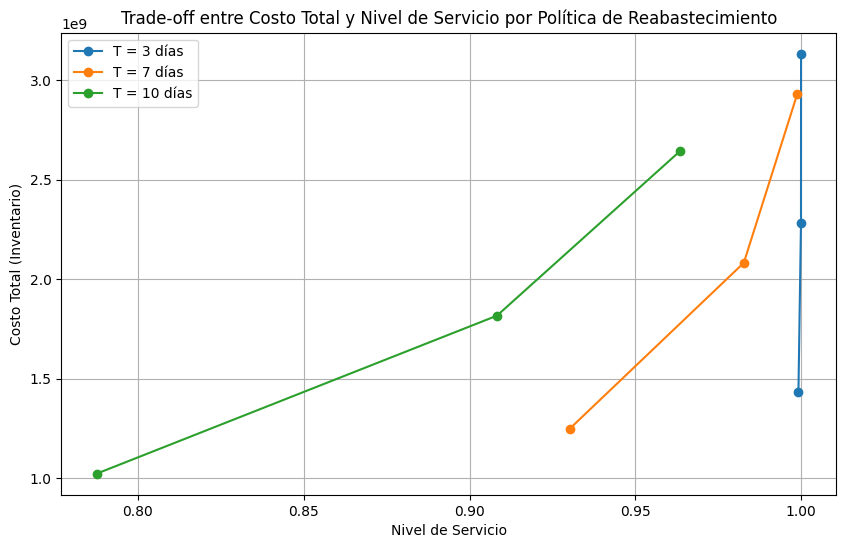

In [117]:
plt.figure(figsize=(10, 6))
for T in df_sensibilidad['T'].unique():
    subset = df_sensibilidad[df_sensibilidad['T'] == T]
    plt.plot(subset['Nivel_Servicio'], subset['Costo_Inventario_Total']*4, marker='o', label=f'T = {T} días')

plt.xlabel('Nivel de Servicio')
plt.ylabel('Costo Total (Inventario)')
plt.title('Trade-off entre Costo Total y Nivel de Servicio por Política de Reabastecimiento')
plt.legend()
plt.grid(True)
plt.show()


In [107]:
factores_Q = [0.01, 0.05, 0.1]
frecuencias_T = [7, 14]
dias_simulados = 10
costo_unitario = 3.733

resultados_sensibilidad = []

for Q in factores_Q:
    for T in frecuencias_T:
        res = simular_gestion_inventario(Q_factor=Q, T=T, dias=dias_simulados, costo_inventario_unitario=costo_unitario)
        resultados_sensibilidad.append({
            'Q_factor': Q,
            'T': T,
            'Nivel_Servicio': res['Nivel_Servicio'],
            'Costo_Inventario_Total': res['Costo_Inventario_Total'],
            'Costo_Diario_Promedio': res['Costo_Diario_Promedio'],
            'Demanda_No_Atendida_Total': res['Demanda_No_Atendida_Total']
        })

df_sensibilidad = pd.DataFrame(resultados_sensibilidad)
print(df_sensibilidad)


   Q_factor   T  Nivel_Servicio  Costo_Inventario_Total  \
0      0.01   7        0.443501            2.062179e+07   
1      0.01  14        0.240909            1.093517e+07   
2      0.05   7        0.929695            3.118881e+08   
3      0.05  14        0.787842            2.558234e+08   
4      0.10   7        0.998820            7.324329e+08   
5      0.10  14        0.963361            6.616244e+08   

   Costo_Diario_Promedio  Demanda_No_Atendida_Total  
0           2.062179e+06                    5239467  
1           1.093517e+06                    7147149  
2           3.118881e+07                     662986  
3           2.558234e+07                    1996804  
4           7.324329e+07                      11105  
5           6.616244e+07                     345050  


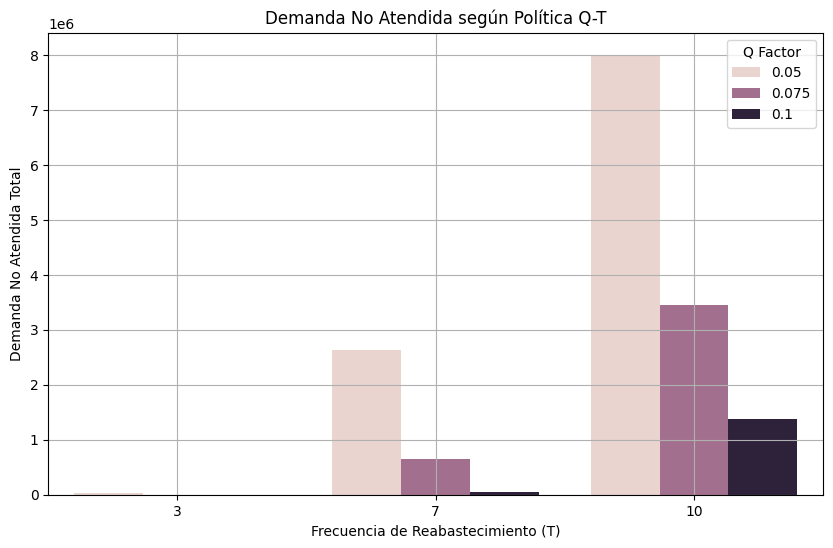

In [118]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_sensibilidad,
    x='T',
    y='Demanda_No_Atendida_Total',
    hue='Q_factor'
)
plt.xlabel('Frecuencia de Reabastecimiento (T)')
plt.ylabel('Demanda No Atendida Total')
plt.title('Demanda No Atendida según Política Q-T')
plt.grid(True)
plt.legend(title='Q Factor')
plt.show()


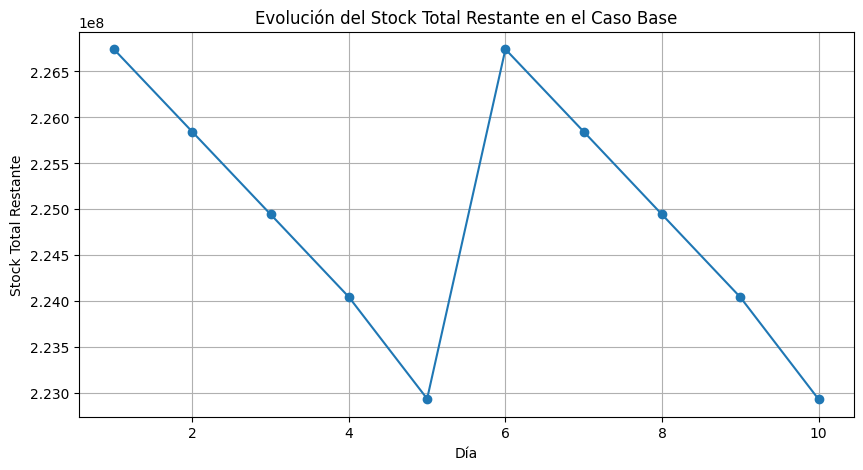

In [119]:
stock_por_dia = resultados_df.groupby('dia')['stock_restante'].sum().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(stock_por_dia['dia'], stock_por_dia['stock_restante'], marker='o')
plt.xlabel('Día')
plt.ylabel('Stock Total Restante')
plt.title('Evolución del Stock Total Restante en el Caso Base')
plt.grid(True)
plt.show()
